# Imports

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE
import xgboost

from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Settings

In [18]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


# Read data

In [19]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Adding building ID

In [20]:
train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Combine data

In [21]:
# Combine Data
X_o = pd.concat([X_train_observed_a, X_train_observed_b, X_train_observed_c])
X_e = pd.concat([X_train_estimated_a, X_train_estimated_b, X_train_estimated_c])
X_t = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
y = pd.concat([train_a, train_b, train_c])

# remove rows without pv_measurement
y = y[y['pv_measurement'].notna()]

# Add time column that only holds the hour
X_o['time'] = X_o['date_forecast'].dt.floor('H')
X_e['time'] = X_e['date_forecast'].dt.floor('H')
X_t['time'] = X_t['date_forecast'].dt.floor('H')

# Add monthYear column
X_o['month'] = X_o['date_forecast'].dt.to_period('M')
X_e['month'] = X_e['date_forecast'].dt.to_period('M')
X_t['month'] = X_t['date_forecast'].dt.to_period('M')

# Prepare for joining ->The data is grouped per building and hour
X_o = X_o.groupby(['building_id', 'time']).mean().reset_index()
X_e = X_e.groupby(['building_id', 'time']).mean().reset_index()
X_t = X_t.groupby(['building_id', 'time']).mean().reset_index()

# Create additional feature for estimated data "delta_forecast"
X_e['delta_forecast'] = (X_e['time']-X_e['date_calc']).apply(lambda x: x.total_seconds() / 3600)
X_t['delta_forecast'] = (X_t['time']-X_t['date_calc']).apply(lambda x: x.total_seconds() / 3600)


# Join the data
Xy_o = pd.merge(X_o, y, on=['building_id', 'time'], how='inner')
Xy_e = pd.merge(X_e, y, on=['building_id', 'time'], how='inner')
# no y for test data 

#TODO: remove, only for testing
# shuffle XY_o
#Xy_o = Xy_o.sample(frac=1).reset_index(drop=True)


# Join might have removed some rows -> create X_o and X_e from Xy_o and Xy_e
X_o = Xy_o.drop(columns=['pv_measurement'])
X_e = Xy_e.drop(columns=['pv_measurement'])

# Get y for observed and estimated data
y_o = Xy_o['pv_measurement']
y_e = Xy_e['pv_measurement']



# Preprocessing

In [22]:
# Class to scale y
class Y_Scaler_divide_by_mean:
    def __init__(self):
        self.mean_per_building = {}

    def fit(self, y , cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.mean_per_building = y_bid.groupby('cat')['y'].mean().to_dict()
        return self
        
    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(lambda row: row['y'] / self.mean_per_building[row['cat']], axis=1)
        return y
    
    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)
    
    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(lambda row: row['y'] * self.mean_per_building[row['cat']], axis=1)
        return y

In [23]:
# Class to scale y
class Y_Scaler_standardize_per_building:
    def __init__(self):
        self.mean_per_building = {}
        self.std_per_building = {}

    def fit(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.mean_per_building = y_bid.groupby('cat')['y'].mean().to_dict()
        self.std_per_building = y_bid.groupby('cat')['y'].std().to_dict()
        return self

    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(lambda row: (row['y'] - self.mean_per_building[row['cat']]) / self.std_per_building[row['cat']],axis=1)
        return y

    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)

    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(lambda row: row['y'] * self.std_per_building[row['cat']] + self.mean_per_building[row['cat']], axis=1)
        return y


In [24]:
# Class to scale y
class Y_Scaler_MaxAbs_per_building:
    def __init__(self):
        self.max_per_building = {}

    def fit(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.max_per_building = y_bid.groupby('cat')['y'].max().to_dict()
        return self

    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] / self.max_per_building[row['cat']], axis=1)
        return y

    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)

    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] * self.max_per_building[row['cat']], axis=1)
        return y


In [25]:
# Class to scale y
class Y_Scaler_QuantileAbs_per_building:
    def __init__(self, quantile):
        self.quantile = quantile
        self.quantile_per_building = {}

    def fit(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.quantile_per_building = y_bid.groupby('cat')['y'].quantile(q=self.quantile).to_dict()
        return self

    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] / self.quantile_per_building[row['cat']], axis=1)
        return y

    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)

    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] * self.quantile_per_building[row['cat']], axis=1)
        return y


In [26]:
# Scale y
y_scaler = Y_Scaler_MaxAbs_per_building()
y_o = y_scaler.fit_transform(y_o, X_o['building_id'])
y_e = y_scaler.transform(y_e, X_e['building_id']) # no fit_transform because we use y_e as test data


# Scale whole y
full_scaler = RobustScaler()
y_o = full_scaler.fit_transform(y_o.values.reshape(-1, 1)).flatten()
y_e = full_scaler.transform(y_e.values.reshape(-1, 1)).flatten() # no fit_transform because we use y_e as test data


In [27]:
# drop irrelevant columns
drop_cols = ['time', 'date_forecast', 'snow_density:kgm3','month','date_calc']
X_o = X_o.drop(drop_cols, axis=1, errors='ignore') # ignore if column does not exist
X_e = X_e.drop(drop_cols, axis=1, errors='ignore') # ignore if column does not exist
X_t = X_t.drop(drop_cols, axis=1, errors='ignore') # ignore if column does not exist

In [28]:
# Feature selection
important_features = [
    #'clear_sky_rad:W',
    'direct_rad:W',
    #'sun_elevation:d',
    'building_id']

#X_o = X_o[important_features]
#X_e = X_e[important_features]
#X_t = X_t[important_features]


In [29]:
# setting types of columns

# manually set types
# categorical_features = [
#     'building_id'
# ]

# impute_features = [
#     "cloud_base_agl:m",
#     "ceiling_height_agl:m",
# ]

# automatically set types
categorical_features = X_o.select_dtypes(include=['object']).columns.tolist()
impute_features = X_o.loc[:,X_o.isna().any()].columns.tolist()


# Building the pipeline

In [30]:


# BayesSearchCV
parameters_bayes = {
    'estimator__n_estimators': Integer(50,700),
    'estimator__max_depth': Integer(6, 15),
    'estimator__learning_rate': Real(0.01, 0.5),
    'estimator__subsample': Real(0.5, 1.0),
    'estimator__colsample_bytree': Real(0.8, 1.0),
    'estimator__colsample_bylevel': Real(0.8, 1.0),
    'estimator__colsample_bynode': Real(0.8, 1.0),
    'estimator__gamma': Real(0, 2),
    'estimator__reg_alpha': Real(0, 2),
    'estimator__reg_lambda': Real(0.9, 2),
    'estimator__min_child_weight': Integer(1, 5),
    'estimator__max_delta_step': Integer(0, 5)
}

# GridSearchCV


parameters_grid = {
    'estimator__n_estimators': [400, 500],
    'estimator__max_depth': [6, 10],
    'estimator__learning_rate': [0.1],
    'estimator__subsample': [0.9, 1.0],
    # 'estimator__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    # 'estimator__gamma': [0, 0.5, 1, 1.5, 2],
    # 'estimator__reg_alpha': [4, 8, 12, 16, 20],
    # 'estimator__reg_lambda': [4, 8, 12, 16, 20],
}

parameters_grid = {
    'estimator__n_estimators': [200],
    'estimator__max_depth': [12],
    'estimator__learning_rate': [0.1],
    'estimator__subsample': [0.9],
    # 'estimator__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    # 'estimator__gamma': [0, 0.5, 1, 1.5, 2],
    # 'estimator__reg_alpha': [4, 8, 12, 16, 20],
    # 'estimator__reg_lambda': [4, 8, 12, 16, 20],
}


In [31]:
from sklearn.base import BaseEstimator, TransformerMixin


class StatusSaver(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # append "1," to status file
        with open('status.csv', 'a') as f:
            f.write('1\n')
        
        return self

    def transform(self, X):
        # Your transformation logic here
        # Return the transformed data
        return X


In [32]:

# create empty txt file
open('status.csv', 'w').close()


# set column transformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

# build the pipeline
pipeline = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('status', StatusSaver()),
    ('estimator', xgboost.XGBRegressor(random_state=42))
])

# create bayesian search estimator
m1_BayesCV = BayesSearchCV(
    pipeline, parameters_bayes, scoring='neg_mean_absolute_error', cv=3, error_score='raise',n_points=2, n_jobs=-1, verbose=2, n_iter=150, random_state=42)


m1_GridCV = GridSearchCV(
    pipeline, parameters_grid, scoring='neg_mean_absolute_error', cv=3, error_score='raise', n_jobs=-1, verbose=2)

# switch between BayesCV and GridCV
m1_CV = m1_BayesCV

# fit the estimator on the data
m1_CV.fit(X_o, y_o)

# get best model 
m1 = m1_CV.best_estimator_


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END estimator__colsample_bylevel=0.8356167836792129, estimator__colsample_bynode=0.9264191256300771, estimator__colsample_bytree=0.8155782458274513, estimator__gamma=1.33365779402875, estimator__learning_rate=0.3445461539133722, estimator__max_delta_step=4, estimator__max_depth=6, estimator__min_child_weight=5, estimator__n_estimators=347, estimator__reg_alpha=0.00901411026181398, estimator__reg_lambda=1.8293447297630803, estimator__subsample=0.85462525233671; total time=   1.6s
[CV] END estimator__colsample_bylevel=0.8356167836792129, estimator__colsample_bynode=0.9264191256300771, estimator__colsample_bytree=0.8155782458274513, estimator__gamma=1.33365779402875, estimator__learning_rate=0.3445461539133722, estimator__max_delta_step=4, estimator__max_depth=6, estimator__min_child_weight=5, estimator__n_estimators=347, estimator__reg_alpha=0.00901411026181398, estimator__reg_lambda=1.8293447297630803, estimator__subsample=

In [33]:
# print the scores
print('Best score:', m1_CV.best_score_)
print('Best parameters:', m1_CV.best_params_)
print('All scores:', m1_CV.cv_results_['mean_test_score'])


Best score: -0.30336789916733137
Best parameters: OrderedDict([('estimator__colsample_bylevel', 0.8814110213432887), ('estimator__colsample_bynode', 0.9337512550475374), ('estimator__colsample_bytree', 0.910143283826611), ('estimator__gamma', 0.17433536135173916), ('estimator__learning_rate', 0.06262991812188597), ('estimator__max_delta_step', 1), ('estimator__max_depth', 15), ('estimator__min_child_weight', 2), ('estimator__n_estimators', 202), ('estimator__reg_alpha', 0.8215183548774995), ('estimator__reg_lambda', 1.050783850266007), ('estimator__subsample', 0.7279242554725548)])
All scores: [-0.34092176 -0.34648791 -0.34613701 -0.3053837  -0.31880557 -0.33894237
 -0.31969541 -0.31696262 -0.33651499 -0.30734594 -0.31126114 -0.31283376
 -0.82668992 -0.31054608 -0.32744172 -0.30857959 -0.73854993 -0.30863938
 -0.3056492  -0.3368373  -0.33333495 -0.31181401 -0.30610152 -0.3100054
 -0.31450852 -0.31586192 -0.37519761 -0.32023987 -0.33318565 -0.33951684
 -0.3033679  -0.35843591 -0.3177855

<Axes: xlabel='feature'>

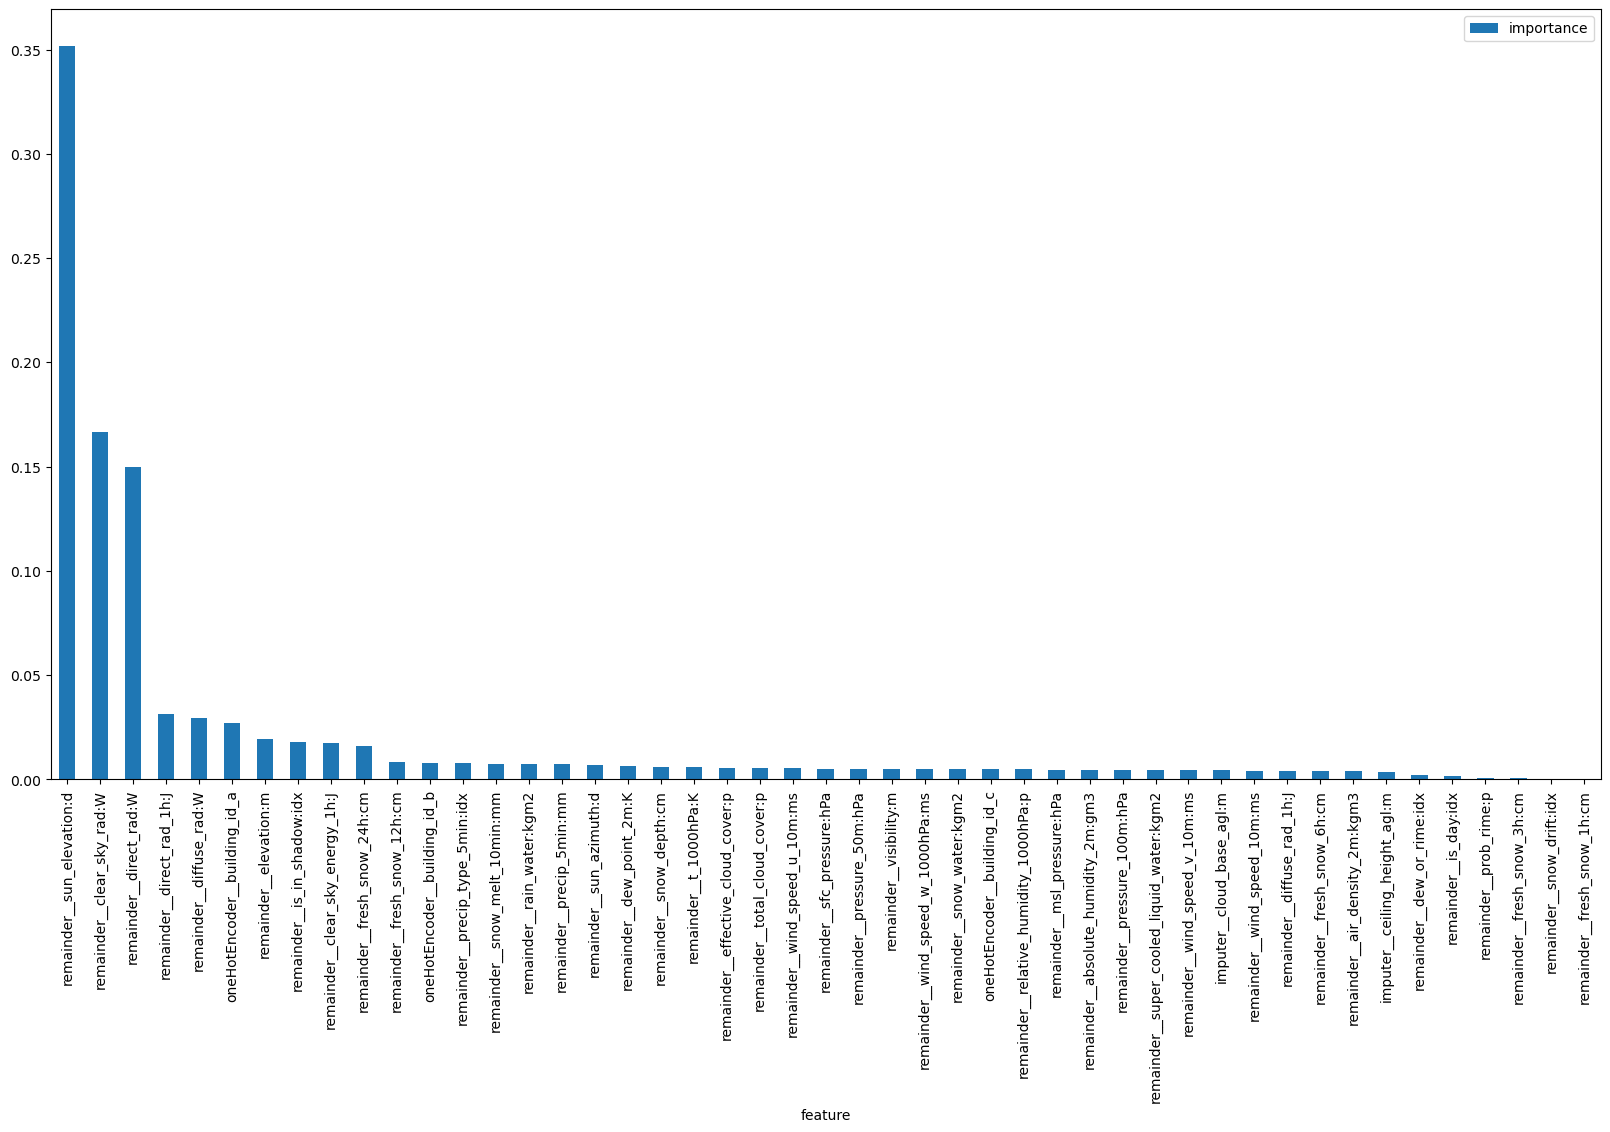

In [35]:
f_names = m1.steps[-3][1].get_feature_names_out()
f_importances = m1.steps[-1][1].feature_importances_

f_importances_df = pd.DataFrame({'feature': f_names, 'importance': f_importances})

f_importances_df = f_importances_df.sort_values(by='importance', ascending=False)

f_importances_df.plot.bar(x='feature', y='importance', figsize=(20, 10))


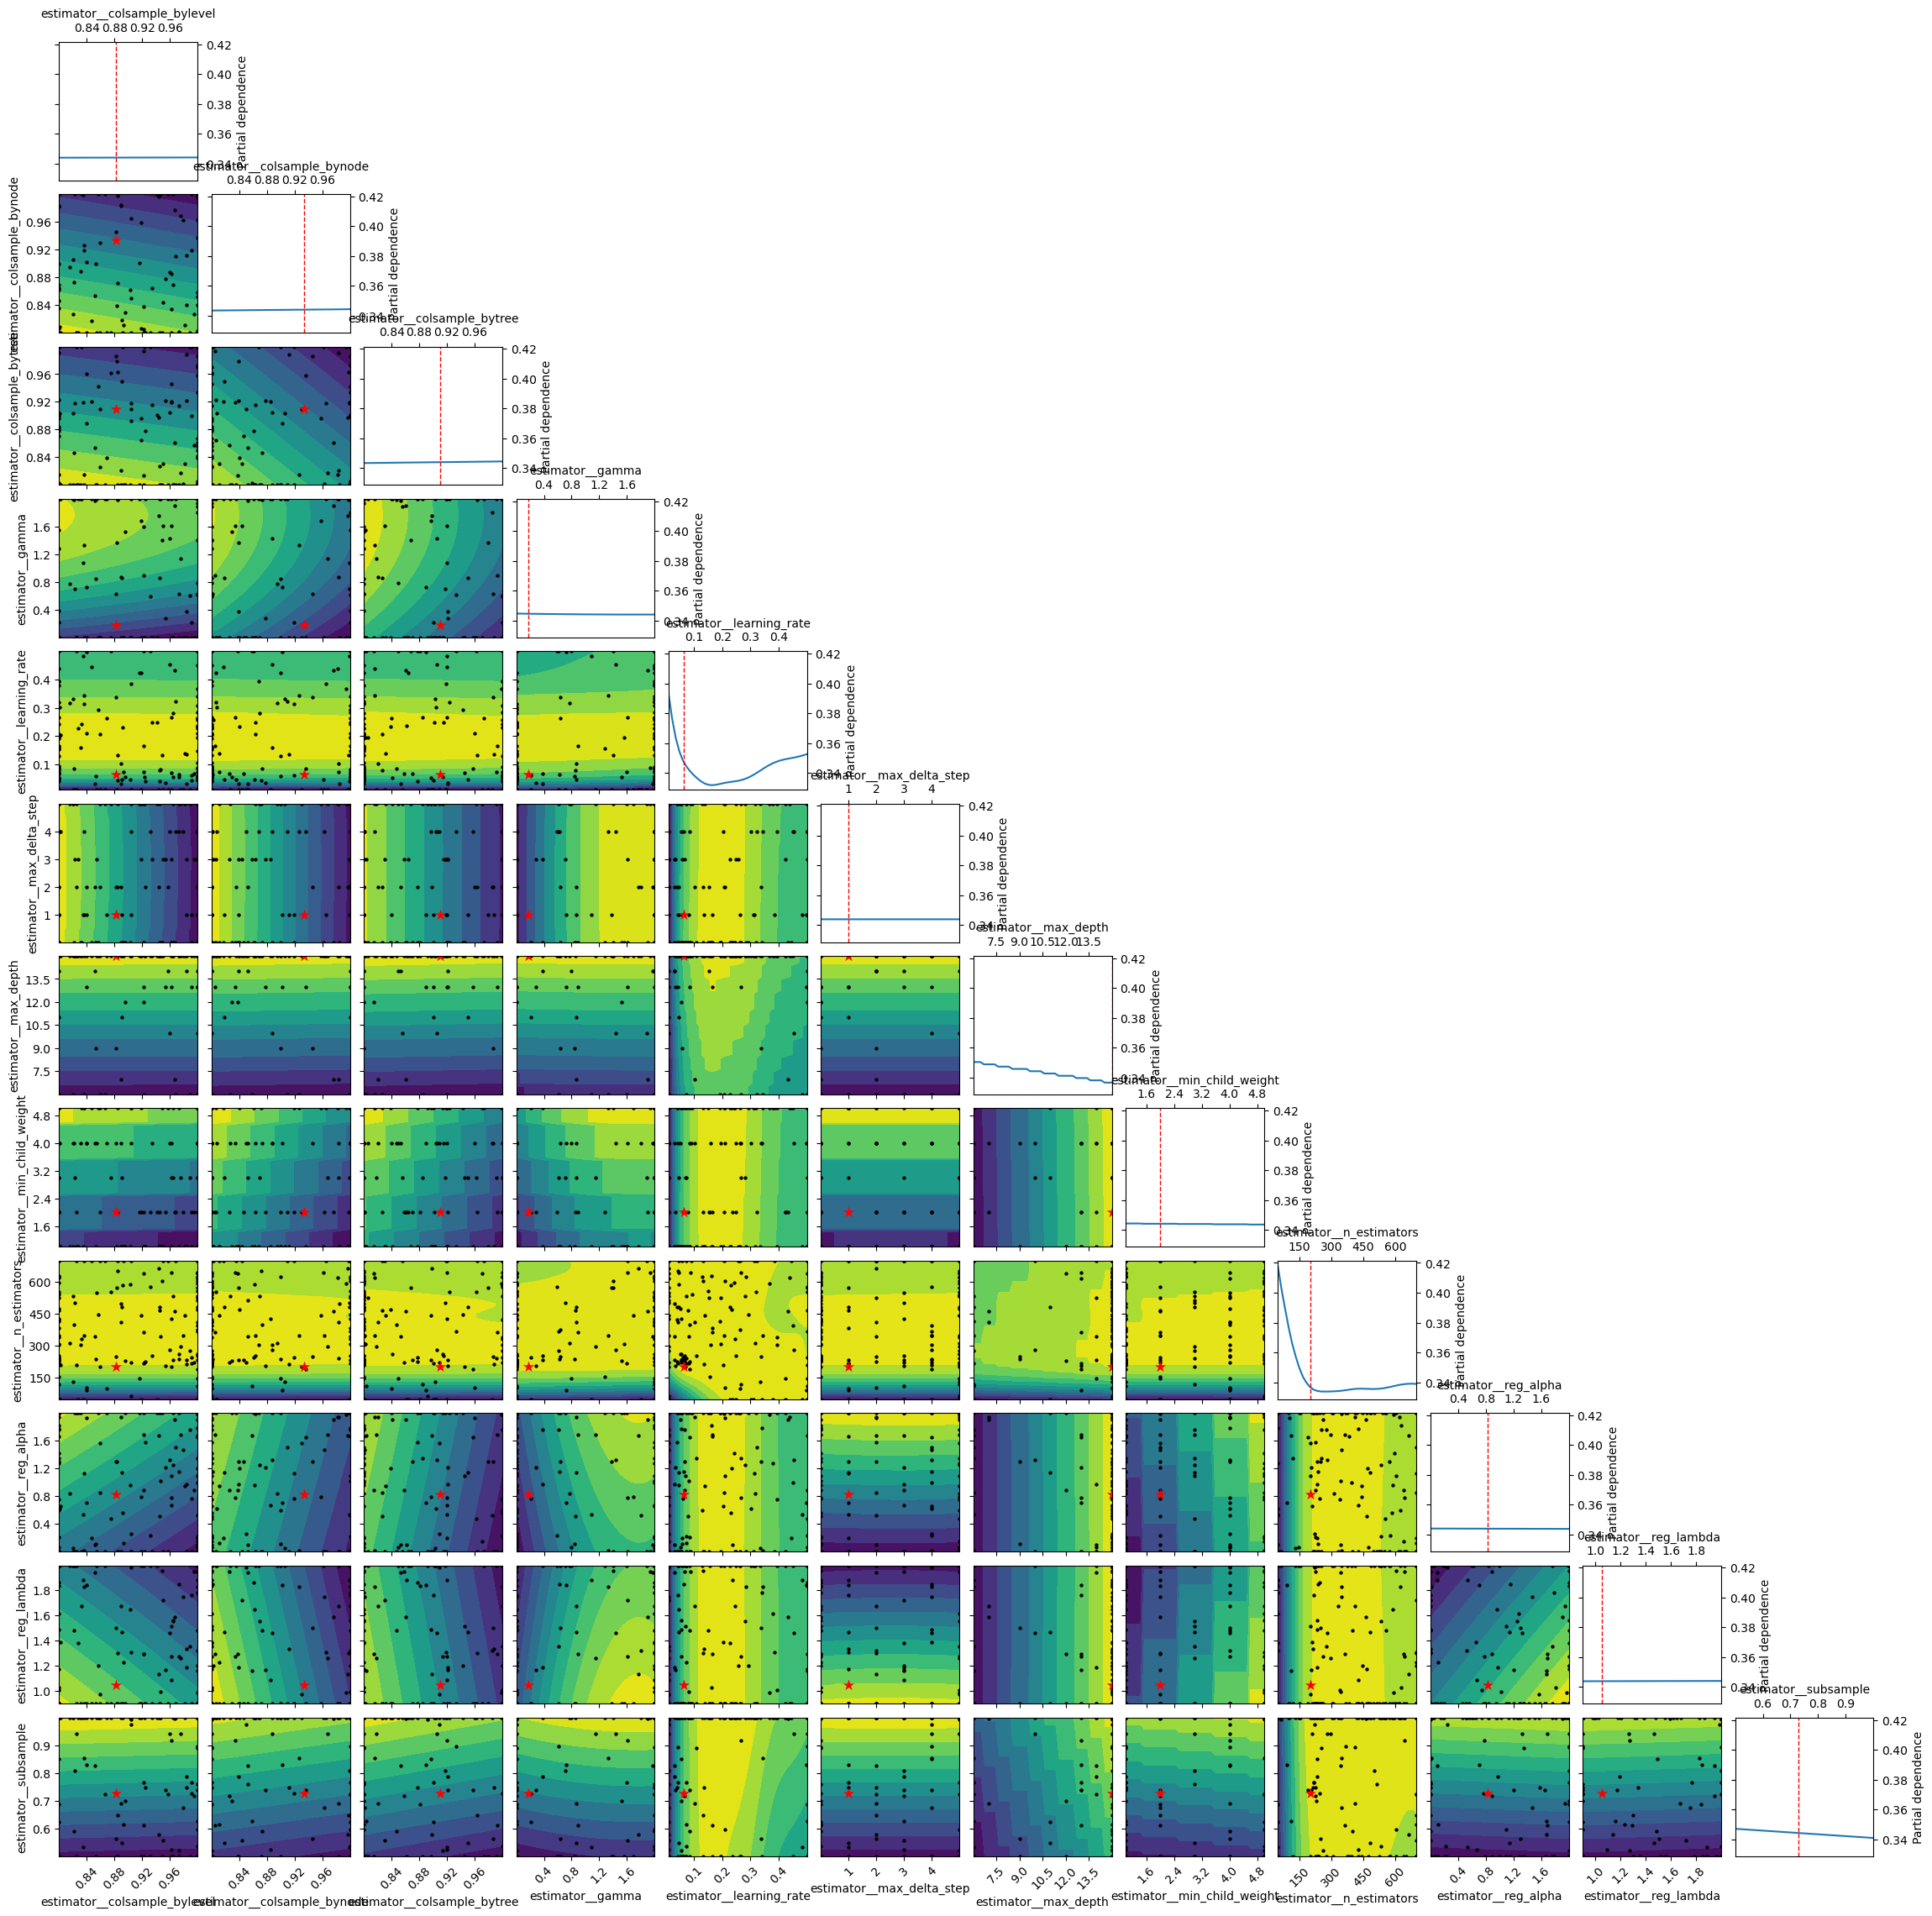

In [36]:
if type(m1_CV) == BayesSearchCV:
    _ = plot_objective(m1_CV.optimizer_results_[0])
    plt.show()

# Test model on estimated data
This is not perfect but should give an indication of how the model performs
The MAE is much lower than the MAE when uploading the predictions to the competition. The reason for this is, that the model has a higher MAE in the summer, where the test set is taken from.

In [37]:
# predict on estimated data
m1_pred = pd.Series(m1.predict(X_e))
m1_pred = pd.Series(full_scaler.inverse_transform(m1_pred.values.reshape(-1, 1)).flatten())
Xy_e['m1_pred'] = y_scaler.inverse_transform(m1_pred, X_e['building_id'])

# calculate abs diff
Xy_e['diff'] = np.abs(Xy_e['pv_measurement'] - Xy_e['m1_pred'])

# calculate mae
mae = Xy_e['diff'].mean()
print('MAE:', mae)


MAE: 63.278985166824846


<Axes: xlabel='time', ylabel='diff'>

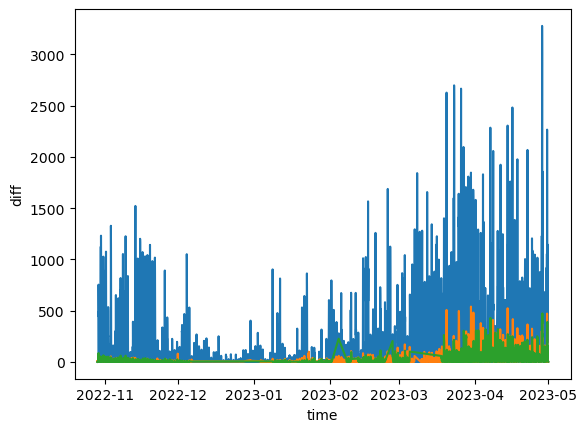

In [38]:
sns.lineplot(data=Xy_e, x='time', y='diff', hue='building_id', legend=False)

In [39]:
# predict on observed data
m1_pred = pd.Series(m1.predict(X_o))
m1_pred = pd.Series(full_scaler.inverse_transform(m1_pred.values.reshape(-1, 1)).flatten())
Xy_o['m1_pred'] = y_scaler.inverse_transform(m1_pred, X_o['building_id'])

# calculate abs diff
Xy_o['diff'] = Xy_o['pv_measurement'] - Xy_o['m1_pred']
Xy_o['abs_diff'] = np.abs(Xy_o['diff'])
Xy_o['diff_perc'] = Xy_o['abs_diff'] / Xy_o['pv_measurement']


# calculate mae
mae = Xy_o['abs_diff'].mean()
print('MAE:', mae)


MAE: 23.880763372793815


In [40]:
Xy_o

,building_id,time,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,month,pv_measurement,m1_pred,diff,abs_diff,diff_perc
0,a,2019-06-02 22:00:00,2019-06-02 22:22:30,7.700,1.22825,1728.949951,0.000000,0.000000,1728.949951,0.0,280.299988,0.000000,0.000000,0.00,0.000000,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1006.299988,0.0000,0.00,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,NaN,0.0,0.0,0.0,0.175,348.036743,-3.774250,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,2019-06,0.00,1.335829,-1.335829,1.335829,inf
1,a,2019-06-02 23:00:00,2019-06-02 23:22:30,7.700,1.22350,1689.824951,0.000000,0.000000,1689.824951,0.0,280.299988,0.000000,0.000000,0.00,0.000000,99.750000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1005.200012,0.0000,0.00,992.674988,998.650024,0.0,0.025,68.000000,1004.650024,NaN,0.0,0.0,0.0,0.200,91.980751,-4.357250,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,2019-06,0.00,2.566881,-2.566881,2.566881,inf
2,a,2019-06-03 00:00:00,2019-06-03 00:22:30,7.875,1.21975,1563.224976,0.000000,0.000000,1563.224976,0.0,280.649994,0.000000,0.000000,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1004.525024,0.0000,0.00,992.000000,997.974976,0.0,0.100,67.949997,1003.950012,NaN,0.0,0.0,0.0,0.400,14.934750,-3.309500,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,2019-06,0.00,2.183045,-2.183045,2.183045,inf
3,a,2019-06-03 01:00:00,2019-06-03 01:22:30,8.425,1.21800,1283.425049,208.649994,0.750000,1283.425049,0.0,281.674988,0.300000,526.775024,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.00,1004.025024,0.0000,0.00,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,NaN,0.0,0.0,0.0,0.550,28.630251,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,2019-06,0.00,13.432635,-13.432635,13.432635,inf
4,a,2019-06-03 02:00:00,2019-06-03 02:22:30,8.950,1.21800,1003.500000,32468.150391,23.100000,1003.500000,0.0,282.500000,11.975000,22068.949219,0.15,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,1003.099976,0.0000,0.00,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.250,41.997501,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,2019-06,19.36,77.391139,-58.031139,58.031139,2.997476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82021,c,2022-04-25 17:00:00,2022-04-25 17:22:30,4.800,1.26350,963.100037,714495.875000,135.699997,652.849976,0.0,273.349976,59.724998,302639.843750,11.05,112344.523438,94.599998,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,1019.299988,0.0000,0.00,1003.500000,1009.674988,0.0,0.000,67.474998,1015.875000,NaN,0.0,0.0,0.0,0.000,277.333984,11.023001,0.1,277.600006,94.599998,37207.449219,3.950,2.800,-2.825,0.0,2022-04,98.00,75.132808,22.867192,22.867192,0.233339
82022,c,2022-04-25 18:00:00,2022-04-25 18:22:30,4.800,1.26525,1177.599976,299217.843750,39.000000,705.099976,0.0,273.299988,21.775000,146764.953125,1.60,22766.199219,71.824997,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.75,1019.400024,0.0025,0.25,1003.599976,1009.750000,0.0,0.000,66.775002,1016.000000,NaN,0.0,0.0,0.0,0.000,290.590515,4.515250

<Axes: xlabel='time', ylabel='diff'>

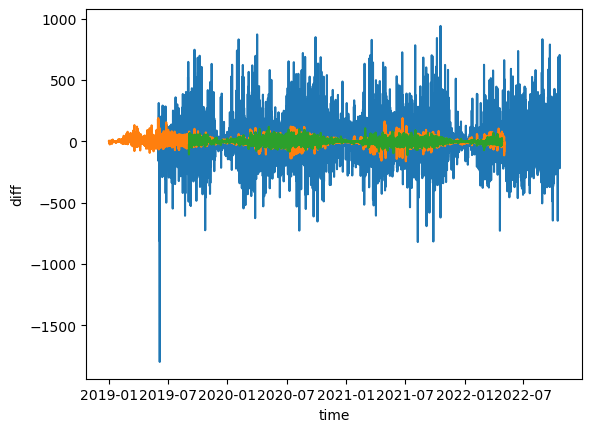

In [41]:
sns.lineplot(data=Xy_o, x='time', y='diff', hue='building_id', legend=False)

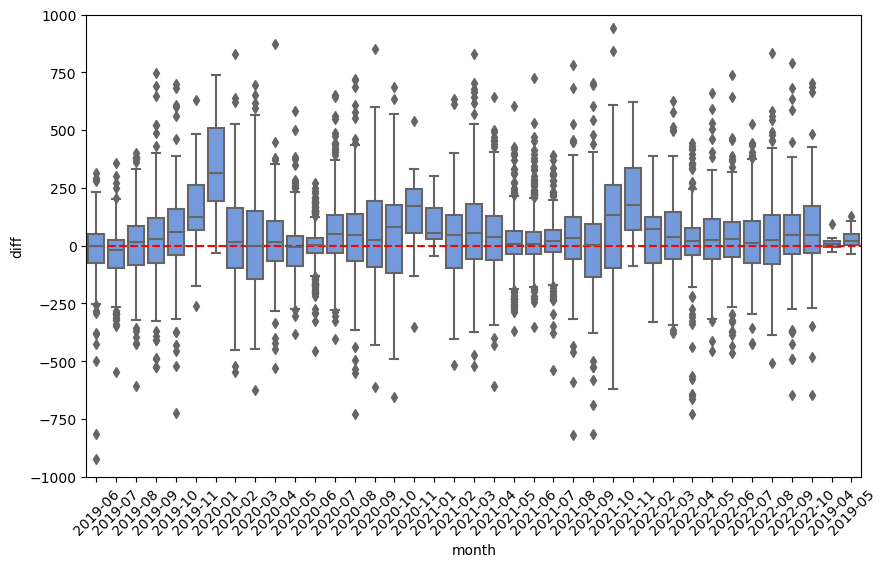

In [42]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.set_ylim([-1000, 1000])
sns.boxplot(data=Xy_o[Xy_o.m1_pred > 800], x='month', y='diff',color='cornflowerblue', ax=ax)
ax.axhline(y=0, color='red', linestyle='--')


<Axes: xlabel='month', ylabel='diff_perc'>

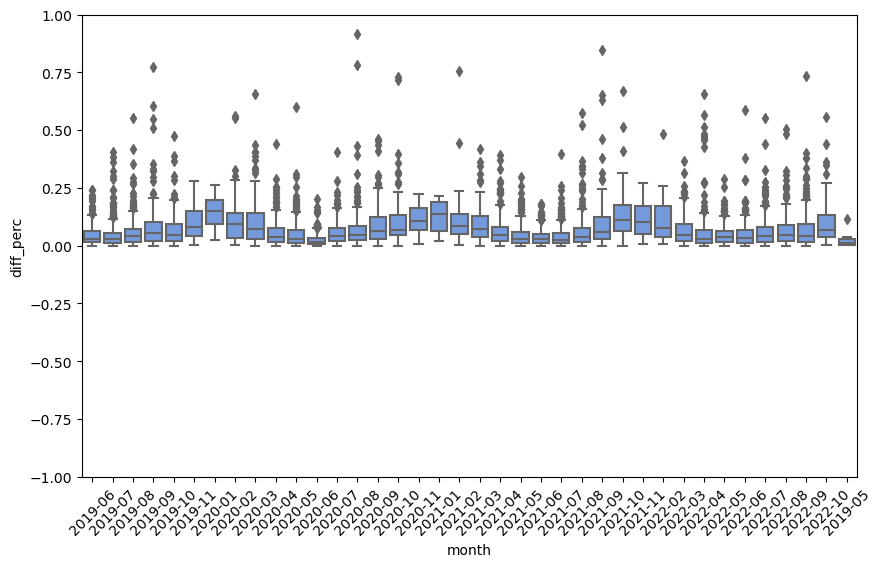

In [43]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.set_ylim([-1, 1])
sns.boxplot(data=Xy_o[Xy_o.m1_pred > 1000], x='month', y='diff_perc',color='cornflowerblue', ax=ax)

In [44]:
# Creating the submission file --> will later be done further below; just to test accuracy of own test method

# prepare dataframes
y_test_pred = pd.Series(m1.predict(X_t))
y_test_pred = pd.Series(full_scaler.inverse_transform(y_test_pred.values.reshape(-1, 1)).flatten())
y_test_pred = y_scaler.inverse_transform(y_test_pred, X_t['building_id']).copy()

# remove negative predictions
y_test_pred.iloc[y_test_pred<0] = 0

# rename columns etc.
y_test_pred = y_test_pred.reset_index().rename(columns={'pv_measurement': 'prediction','index': 'id'})

# save submission file
y_test_pred.to_csv('XGBOOST_MaxAbsPerBuilding_RobustScaler_noEstimatedTraining.csv', index=False, header=True)


# Model2

In [45]:
# use same scaler as for y_o
y_e = y_scaler.fit_transform(y_e, X_e['building_id'])

AssertionError: 

In [ ]:
X_e['m1_pred'] = m1.predict(X_e)

## second as LinearRegression

from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_e,y_e)

## second as XGBoost

In [ ]:
parameters2 = {
    'estimator__n_estimators': Integer(20, 21),
    'estimator__max_depth': Integer(3, 10),
    'estimator__learning_rate': Real(0.01, 0.5),
    'estimator__subsample': Real(0.5, 1.0),
    'estimator__colsample_bytree': Real(0.5, 1.0),
    'estimator__gamma': Real(0, 5),
    'estimator__reg_alpha': Real(0, 5),
    'estimator__reg_lambda': Real(0, 5),
}

In [ ]:
# set relevant columns
rel_cols = ['building_id','delta_forecast','m1_pred']

# automatically set types
categorical_features = X_t.select_dtypes(include=['object']).columns.tolist()
impute_features = X_t.loc[:, X_t.isna().any()].columns.tolist()

In [ ]:
# set column transformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='mean'), impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

# build the pipeline
pipeline = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('estimator', xgboost.XGBRegressor(random_state=42))
])



m2_BayesCV = BayesSearchCV(
    pipeline, parameters2, scoring='neg_mean_absolute_error', cv=6, error_score='raise', n_jobs=-1, verbose=1, n_iter=20, random_state=42)



# fit the estimator on the data
m2_BayesCV.fit(X_e, y_e)

# fit best model on the data
m2 = m2_BayesCV.best_estimator_
m2.fit(X_e, y_e)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer', SimpleImputer(),
                                                  ['ceiling_height_agl:m',
                                                   'cloud_base_agl:m']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_id'])])),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsam...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.45063815899592613, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=21, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# print the scores
print('Best score:', m2_BayesCV.best_score_)
print('Best parameters:', m2_BayesCV.best_params_)
print('All scores:', m2_BayesCV.cv_results_['mean_test_score'])


Best score: -0.02607318072462185
Best parameters: OrderedDict([('estimator__colsample_bytree', 0.729270722110062), ('estimator__gamma', 0.04083794976558975), ('estimator__learning_rate', 0.45063815899592613), ('estimator__max_depth', 10), ('estimator__n_estimators', 21), ('estimator__reg_alpha', 1.062473634693932), ('estimator__reg_lambda', 1.9435355459201686), ('estimator__subsample', 0.7663676494085123)])
All scores: [-0.03637843 -0.0401481  -0.04659085 -0.03086022 -0.03516055 -0.04134935
 -0.03987496 -0.04013563 -0.0382455  -0.04116714 -0.02745265 -0.02922056
 -0.07200476 -0.0274728  -0.02712525 -0.02607318 -0.04087775 -0.03056394
 -0.02849597 -0.03031447]


# Final prevision

In [ ]:
X_t['m1_pred'] = m1.predict(X_t)
X_t['m2_pred'] = m2.predict(X_t)

In [ ]:
# multiply by mean per building id
X_t['m2_pred'] = y_scaler.inverse_transform(X_t['m2_pred'], X_t['building_id'])

# make negative predictions 0
X_t.loc[X_t['m2_pred'] < 0, 'm2_pred'] = 0

# create submission file
submission = X_t['m2_pred'].copy().reset_index(name='prediction')

submission = submission.rename(columns={'index': 'id'})

submission.to_csv('XGBOOSTx2.csv', index=False, header=True)


In [ ]:
X_t

,building_id,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,delta_forecast,m1_pred,m2_pred
0,a,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,0.0,0.0,0.0,0.0,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,16.998889,-0.000029,0.001008
1,a,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,0.0,0.0,0.0,0.0,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,17.998889,-0.000282,0.001008
2,a,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,0.0,0.0,0.0,0.0,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,18.998889,-0.000151,0.001008
3,a,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1012.174988,0.0,0.0,998.974976,1005.224976,0.0,0.0,75.625000,1011.525024,0.0,0.0,0.0,0.0,58.083000,1.412500,0.000,273.899994,68.599998,34552.500000,3.500,1.450,3.150,0.0,19.998889,0.012871,0.001706
4,a,3.900,1.28100,2198.299805,141748.593750,76.875000,920.049988,0.0,270.375000,47.400002,102209.703125,25.450001,49571.199219,66.300003,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1011.724976,0.0,0.0,998.549988,1004.750000,0.0,0.0,74.224998,1011.049988,0.0,0.0,0.0,0.0,71.341003,7.468500,0.000,273.924988,66.300003,35483.875000,3.325,1.300,3.050,0.0,20.998889,0.060147,0.054187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,c,8.400,1.19675,3493.649902,475981.375000,84.775002,1967.375000,0.0,281.700012,32.200001,162567.531250,13.450001,53064.921875,87.474998,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,992.150024,0.0,0.0,977.575012,983.400024,0.0,0.0,71.650002,989.299988,0.0,0.0,0.0,0.0,306.688995,8.131001,0.100,286.850006,88.175003,41007.898438,2.175,1.900,-1.075,0.0,35.991389,0.036762,0.035681
2156,c,8.600,1.20000,3078.750000,183261.343750,24.549999,1449.500000,0.0,282.024994,13.875000,82875.351562,2.400000,28523.800781,78.074997,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.5,992.575012,0.0,0.0,977.974976,983.849976,0.0,0.0,75.324997,989.750000,0.0,0.0,0.0,0.0,319.703003,3.239500,0.000,286.450012,78.949997,41315.949219,2.200,2.000,-0.925,0.0,36.991389,0.013527,0.012976
2157,c,8.875,1.20350,2308.399902,36831.074219,1.225000,1543.650024,0.0,282.350006,1.250000,27210.250000,0.000000,4322.475098,79.550003,24.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,992.950012,0.0,0.0,978.250000,984.150024,0.0,0.0,80.425003,990.075012,0.0,0.0,0.0,0.0,333.037231,-0.477000,0.000,285.950012,80.449997,41665.898438,2.250,2.050,-0.950,0.0,37.991389,-0.001230,0.002486
2158,c,9.000,1.20650,2000.449951,344.575012,0.000000,1725.949951,0.0,282.60000

#